In [3]:
import os
import xml.etree.ElementTree as ET
import logging
import sys
import warnings
from functools import reduce
from typing import List

import numpy as np
import torch as th
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from absa import train_reviews_path, test_reviews_path, TEST_APPENDIX, word2vec_model_path, UNKNOWN_WORD, \
                parsed_reviews_dump_path, PROGRESSBAR_COLUMNS_NUM, images_path
from absa.review import get_reviews, load_reviews, dump_reviews, reviews_dump_path
from absa.preprocess.spell_check import spell_check, load_checked_reviews
from absa.preprocess.dep_parse import parse_reviews, load_parsed_reviews, dump_parsed_reviews
from absa.target.polarity.classifier import PolarityClassifier
from absa.utils.embedding import get_embeddings

seed = 42
np.random.seed(seed)
th.manual_seed(seed)
th.cuda.manual_seed(seed)
logging.basicConfig(level=logging.INFO)

Using backend: pytorch


In [4]:
num_epoch = 100

In [5]:
# ___________________________Train_______________________________
train_reviews = load_parsed_reviews(file_pathway=parsed_reviews_dump_path)
train_sentences = [x for x in reduce(lambda x, y: x + y, train_reviews)]

# ___________________________Test________________________________
test_reviews = load_parsed_reviews(file_pathway=parsed_reviews_dump_path + TEST_APPENDIX)
test_sentences = [x for x in reduce(lambda x, y: x + y, test_reviews)]

INFO:root:Upload dependency trees from dump.
INFO:root:Upload dependency trees from dump.


In [6]:
word2vec = get_embeddings()

INFO:gensim.models.utils_any2vec:loading projection weights from /home/dmitry/Projects/absa/embeddings/tayga_upos_skipgram_300_2_2019/model.bin
INFO:gensim.models.utils_any2vec:loaded (249565, 300) matrix from /home/dmitry/Projects/absa/embeddings/tayga_upos_skipgram_300_2_2019/model.bin


## Parameter choice

In [4]:
splits_number = 5

mean_train_hist = np.zeros((num_epoch,))
mean_val_hist = np.zeros((num_epoch,))
kf = KFold(n_splits=splits_number)
for train_index, val_index in kf.split(train_sentences):
    classifier = PolarityClassifier(word2vec=word2vec)
    train_hist, val_hist = classifier.fit([train_sentences[i] for i in train_index], 
                                          [train_sentences[i] for i in val_index], 
                                          num_epoch=num_epoch,
                                          verbose=False)
    mean_train_hist += np.array(train_hist)
    mean_val_hist += np.array(val_hist)
mean_train_hist = mean_train_hist / splits_number
mean_val_hist = mean_val_hist / splits_number

100%|████████████████████████████████████████████████████████████████| 5/5 [31:38<00:00, 379.62s/it]


In [14]:
%store mean_train_hist mean_val_hist

Stored 'mean_train_hist' (ndarray)
Stored 'mean_val_hist' (ndarray)


## Display dep

In [7]:
%store -r

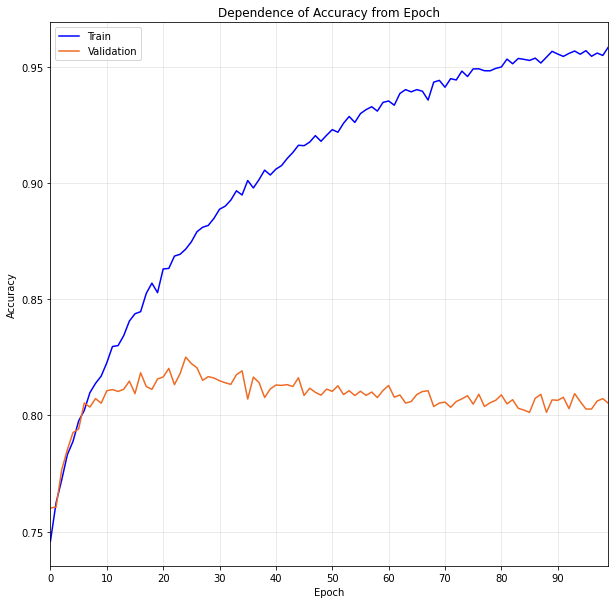

In [10]:
SCORE_NAME = 'Accuracy'
PARAMETER_DECIMAL_LEN = 5
SCORE_DECIMAL_LEN = 3


def display_score(parameter_values: List,
                  train_values: List[float],
                  val_values: List[float],
                  parameter_name='Epoch',
                  score_name=SCORE_NAME) -> float:

    max_param, max_acc = [(parameter_values[index], val)
                          for index, val in enumerate(val_values) if val == max(val_values)][0]

    plt.figure(figsize=(10, 10))
    plt.grid(True, alpha=0.3)
    plt.xlim(left=min(parameter_values), right=max(parameter_values))

    # train
    plt.plot(parameter_values, train_values, color='blue')
    # validation
    plt.plot(parameter_values,
             val_values,
             color='#EE6B24')

    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(f'Dependence of {score_name} from {parameter_name}')
    plt.xlabel(f'{parameter_name}')
    plt.ylabel(score_name.capitalize())
    if isinstance(max_param, (int, )):
        plt.legend([
            f'Maximal {score_name}={max_acc:.{SCORE_DECIMAL_LEN}} when {parameter_name}={max_param}'
        ])
    else:
        plt.legend([
            f'Maximal {score_name}={max_acc:.{SCORE_DECIMAL_LEN}}' +
            f' when {parameter_name}={max_param:.{PARAMETER_DECIMAL_LEN}f}'
        ])
    plt.legend(['Train', 'Validation'])

display_score(parameter_values=[x for x in range(num_epoch)],
              train_values=mean_train_hist,
              val_values=mean_val_hist)
plt.savefig(os.path.join(images_path, 'polarity_classifier_accuracy_vs_epoch.pdf'))